# note3からadamをadamwに変更してみただけ


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [2]:
class BuckConverterCell(nn.Module):
    def __init__(
        self,
        dt: float = 1e-6,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        self.dt = dt
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(
        self, h: torch.Tensor, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        h: [batch, 2] - [i_L, v_C]
        x: [batch, 1] - [v_a]
        """
        i_L = h[:, 0]
        v_C = h[:, 1]
        v_a = x[:, 0].clone()

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # --- DCM対応: 元のコードと同じロジック ---
        # スイッチOFF（va==0）かつ電流がゼロ以下の時、va = v_C（出力電圧）
        idx = (v_a == 0) & (i_L <= 0)
        v_a[idx] = v_C[idx]

        # 実効的なvaを保存（可視化用）
        v_a_eff = v_a.clone()
        # --------------------------------------------

        # オイラー法による状態更新（元のコードと同じ順序）
        # 1. インダクタ電流の更新
        i_L_next = i_L + (self.dt / L) * (v_a - v_C)
        i_L_next = torch.relu(i_L_next)  # 電流は負にならない（DCM考慮）

        # 2. コンデンサ電圧の更新（現在のi_Lを使用）
        v_C_next = v_C + (self.dt / C) * (i_L - v_C / R)

        return torch.stack([i_L_next, v_C_next], dim=1), v_a_eff

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
            "log_L": self.log_L.item(),
            "log_C": self.log_C.item(),
            "log_R": self.log_R.item(),
        }

# BuckConverterCell を使ってシミュレーションデータを作成


In [3]:
# 真値パラメータ（すべてのデータセットで共通）
L_true = 100e-6
C_true = 48e-6
R_true = 10

# 固定のサンプリング周期を使用（最高周波数に合わせる）
base_fs = 1e4  # 基準となる最高周波数
samples_per_cycle = 100
dt = 1 / (base_fs * samples_per_cycle)  # 固定dt
n_samples = 20000  # サンプル数

# データ生成条件のリスト（入力電圧と参照電圧のみ変更）
conditions: list[tuple[float, float]] = [
    # (Vin, Vref)
    (9, 4.5),
    (10, 5),
    (11, 4),
    (11, 5.5),
    (12, 5),
    (12, 6),
    (12, 7),
    (13, 6),
    (13, 6.5),
    (14, 8),
    (15, 7),
    (16, 8),
    (28, 6),
]

datasets = []

for i, (Vin, Vref) in enumerate[tuple[float, float]](conditions):
    print(f"データセット {i + 1}/{len(conditions)} を生成中: Vin={Vin}V, Vref={Vref}V")

    # 方形波生成（固定周波数20kHzでPWM）
    fs_pwm = 20e3  # PWMのスイッチング周波数
    Ts_pwm = 1 / fs_pwm
    t = np.arange(0, n_samples) * dt

    # PWM波形を生成
    vp = np.zeros(n_samples)
    for j in range(n_samples):
        phase = (t[j] % Ts_pwm) / Ts_pwm
        vp[j] = Vin if phase < (Vref / Vin) else 0

    # モデルを作成
    model = BuckConverterCell(dt=dt, L_init=L_true, C_init=C_true, R_init=R_true)

    va_list = []
    il_list = []
    vo_list = []

    # シミュレーション実行
    with torch.no_grad():
        h_current = torch.zeros(1, 2)  # [i_L=0, v_C=0]
        for j in range(len(vp)):
            va_input = torch.tensor([[vp[j]]], dtype=torch.float32)

            # 現在の状態を保存
            il_list.append(h_current[0, 0].item())  # i_L
            vo_list.append(h_current[0, 1].item())  # v_C (= v_o)

            # 次の状態と実効vaを計算
            h_current, va_eff = model(h_current, va_input)

            # 実効的なva（DCM対応済み）を保存
            va_list.append(va_eff[0].item())

    va = np.array(va_list)
    il = np.array(il_list)
    vo = np.array(vo_list)

    datasets.append(
        {
            "Vin": Vin,
            "Vref": Vref,
            "fs": fs_pwm,
            "t": t,
            "vp": vp,
            "va": va,
            "il": il,
            "vo": vo,
            "dt": dt,
        }
    )


# データセットを生成
print(f"\\n生成完了: {len(datasets)}個のデータセット")
print(
    f"真値パラメータ: L={L_true * 1e6:.1f}µH, C={C_true * 1e6:.1f}µF, R={R_true:.1f}Ω"
)
print(f"共通サンプリング周期: dt={dt * 1e6:.3f}µs")

データセット 1/13 を生成中: Vin=9V, Vref=4.5V
データセット 2/13 を生成中: Vin=10V, Vref=5V
データセット 3/13 を生成中: Vin=11V, Vref=4V
データセット 4/13 を生成中: Vin=11V, Vref=5.5V
データセット 5/13 を生成中: Vin=12V, Vref=5V
データセット 6/13 を生成中: Vin=12V, Vref=6V
データセット 7/13 を生成中: Vin=12V, Vref=7V
データセット 8/13 を生成中: Vin=13V, Vref=6V
データセット 9/13 を生成中: Vin=13V, Vref=6.5V
データセット 10/13 を生成中: Vin=14V, Vref=8V
データセット 11/13 を生成中: Vin=15V, Vref=7V
データセット 12/13 を生成中: Vin=16V, Vref=8V
データセット 13/13 を生成中: Vin=28V, Vref=6V
\n生成完了: 13個のデータセット
真値パラメータ: L=100.0µH, C=48.0µF, R=10.0Ω
共通サンプリング周期: dt=1.000µs


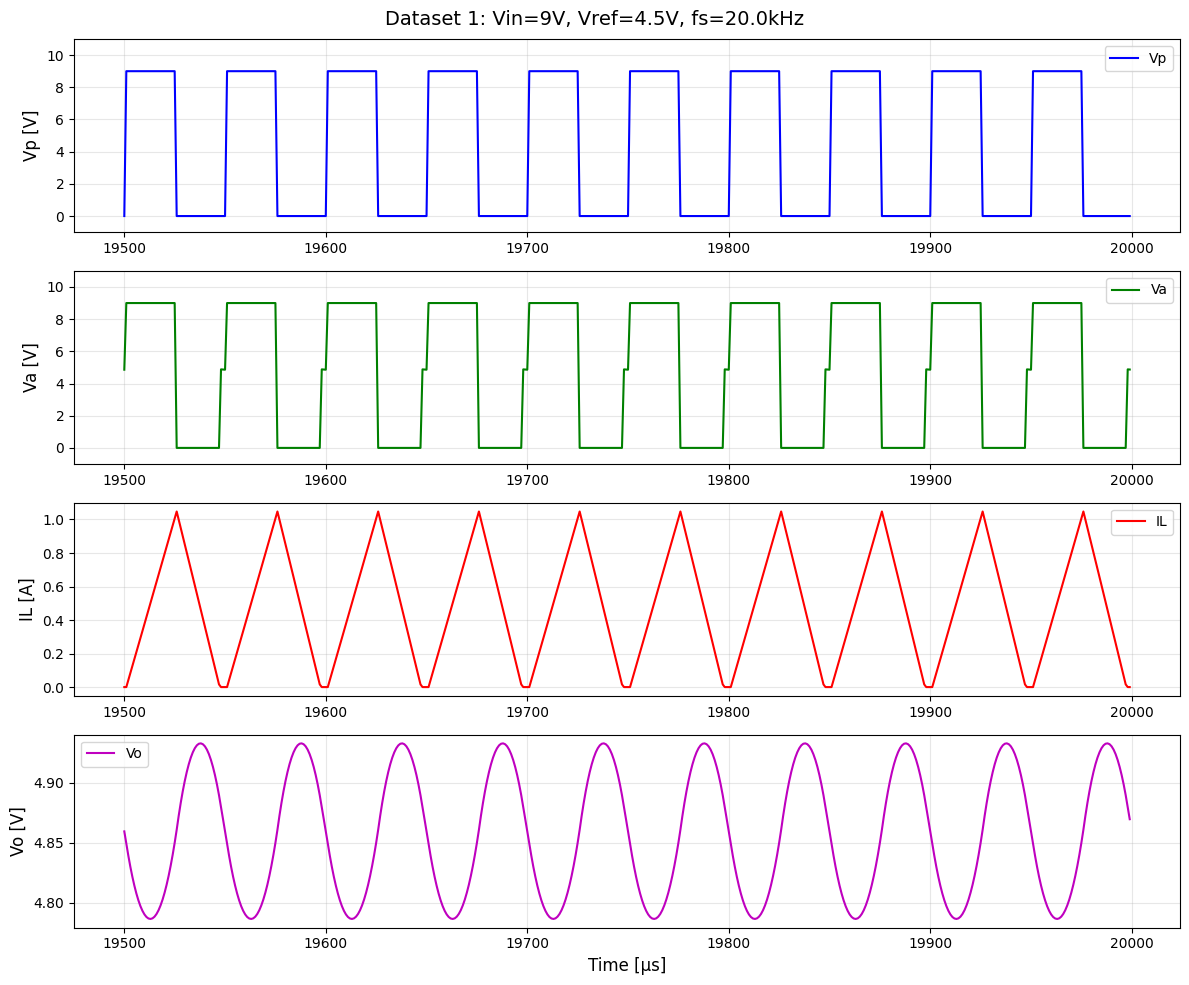

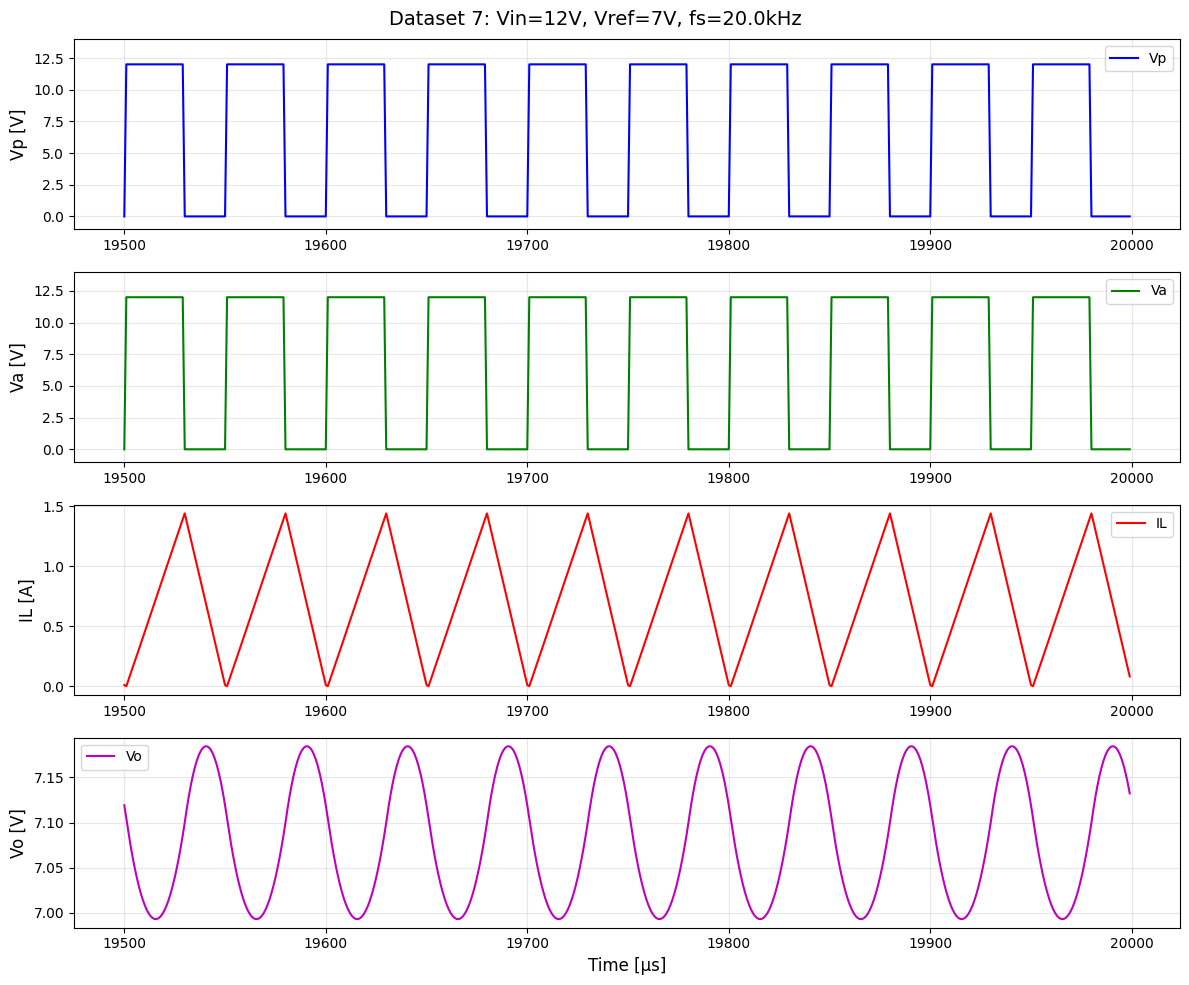

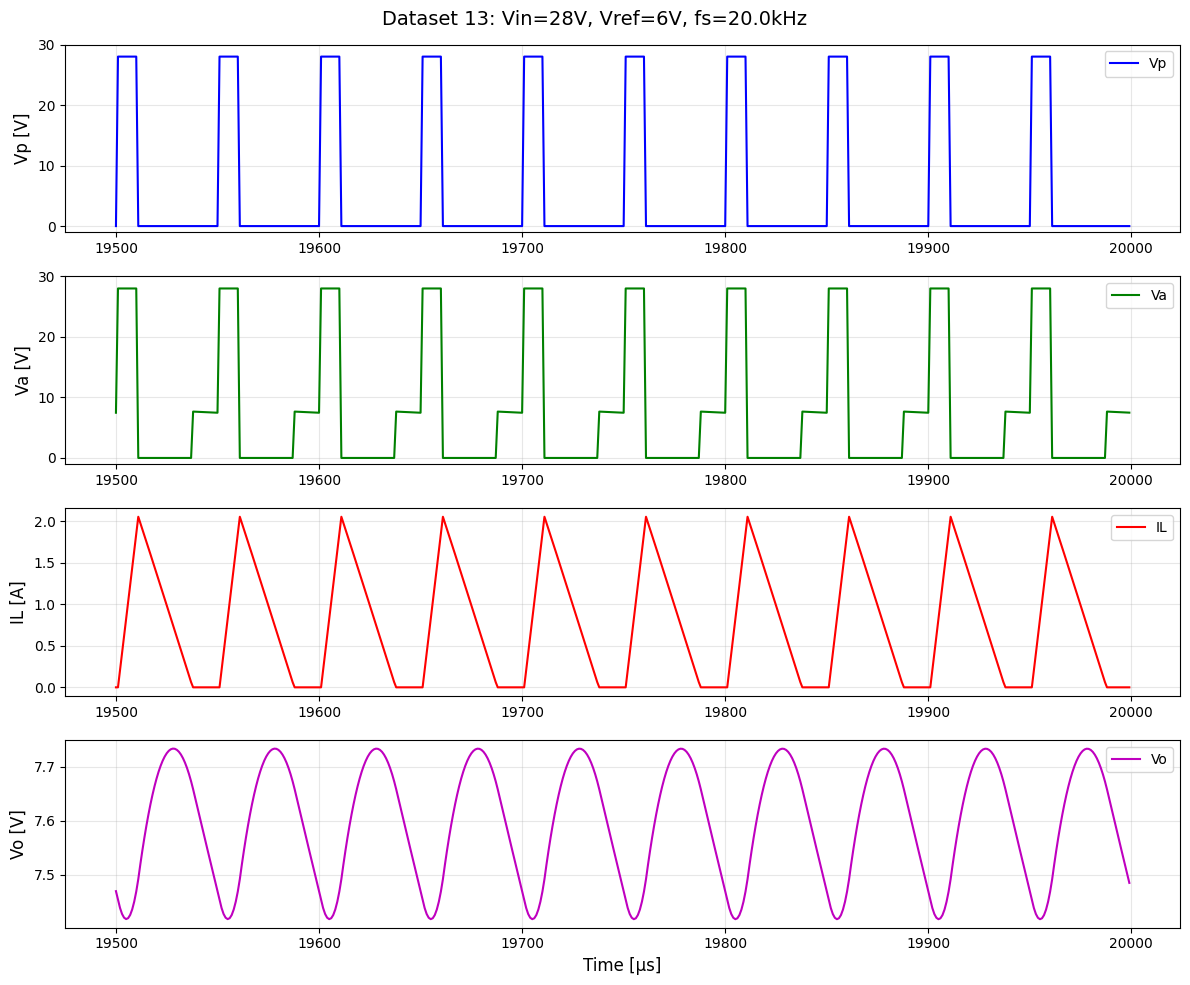

In [4]:
# 生成したデータセットのサンプルを可視化
plot_range = 500

# 最初と中間のデータセットを選んでプロット
for idx in [0, 6, 12]:
    dataset = datasets[idx]
    t = dataset["t"]
    vp = dataset["vp"]
    va = dataset["va"]
    il = dataset["il"]
    vo = dataset["vo"]

    fig, axes = plt.subplots(4, 1, figsize=(12, 10))

    # タイトル
    fig.suptitle(
        f"Dataset {idx + 1}: Vin={dataset['Vin']}V, "
        f"Vref={dataset['Vref']}V, fs={dataset['fs'] / 1e3:.1f}kHz",
        fontsize=14,
    )

    # vp (PWM入力)
    axes[0].plot(
        t[-plot_range:] * 1e6, vp[-plot_range:], "b-", linewidth=1.5, label="Vp"
    )
    axes[0].set_ylabel("Vp [V]", fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(-1, dataset["Vin"] + 2)
    axes[0].legend()

    # va (実効電圧、DCM対応)
    axes[1].plot(
        t[-plot_range:] * 1e6,
        va[-plot_range:],
        "g-",
        linewidth=1.5,
        label="Va",
    )
    axes[1].set_ylabel("Va [V]", fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(-1, dataset["Vin"] + 2)
    axes[1].legend()

    # il (インダクタ電流)
    axes[2].plot(
        t[-plot_range:] * 1e6,
        il[-plot_range:],
        "r-",
        linewidth=1.5,
        label="IL",
    )
    axes[2].set_ylabel("IL [A]", fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    # vo (出力電圧)
    axes[3].plot(
        t[-plot_range:] * 1e6,
        vo[-plot_range:],
        "m-",
        linewidth=1.5,
        label="Vo",
    )
    axes[3].set_ylabel("Vo [V]", fontsize=12)
    axes[3].set_xlabel("Time [µs]", fontsize=12)
    axes[3].grid(True, alpha=0.3)
    axes[3].legend()

    plt.tight_layout()
    plt.show()

# シミュレーションデータを使って回路パラメータの推論


## 現状の主な問題点

1. エポックがかかりすぎる
   1. 先行研究では 75 だが、note3 では 3000 くらいかかった
   2. 学習率を各回路パラメータごとに変える
      1. 先行研究では学習率を回路パラメータごとに変えている
      2. note3 では全て同じ学習率でやった
      3. オーダーが違うのでそれにある程度合わせる
   3. 初期値の取り方
2. 学習データの種類が 1 パターンしかない
   1. 先行研究の方では 2 つの異なる学習データを使っている
3. 回路パラメータが負になってしまうパターンがあることがわかった
   1. 回路パラメータは本来、正の値しかありえないが、学習の過程で負の値になることがある
   2. 先行研究では Clamper と初期値を都合のいいように設定して負にならないようにしているが、初期値や clamp の範囲をいじると負になることがあった
   3. note3 では log と exp を使って正の値を保証している
      1. これはとりあえずおっけい
   4. 問題は、clamp の範囲をどこまでどのように設定すれば正しく学習が進むかわからない
   5. おそらく極端なデータを学習させるとバグる

## このノートブックで実装すること

1. 学習データを 2 つ用意し、学習させる
   1. 回路パラメータを変えずに入力電圧を変える
2. 回路パラメータごとに学習率を変える


In [5]:
# 学習データの準備
train_va = np.stack([dataset["va"] for dataset in datasets])
train_il = np.stack([dataset["il"] for dataset in datasets])
train_vo = np.stack([dataset["vo"] for dataset in datasets])

print(train_va.shape)
print(train_il.shape)
print(train_vo.shape)


(13, 20000)
(13, 20000)
(13, 20000)


In [6]:
# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 1e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 200

# テンソルに変換 - 正しい形状で準備
va_tensor = torch.tensor(train_va[:, :-1], dtype=torch.float32).unsqueeze(-1)

# モデルとオプティマイザの設定
model = BuckConverterCell(dt=dt, L_init=L_init, C_init=C_init, R_init=R_init)

# パラメータごとに異なる学習率を設定
# optimizer = optim.Adam(
#     [
#         {"params": [model.log_L], "lr": lr_L},
#         {"params": [model.log_C], "lr": lr_C},
#         {"params": [model.log_R], "lr": lr_R},
#     ]
# )
optimizer = optim.AdamW(
    [
        {"params": [model.log_L], "lr": lr_L, "weight_decay": 0.001},
        {"params": [model.log_C], "lr": lr_C, "weight_decay": 0.001},
        {"params": [model.log_R], "lr": lr_R, "weight_decay": 0.0001},
    ]
)


loss_fn = nn.MSELoss()

loss_history = []
param_history = {"L": [], "C": [], "R": [], "log_L": [], "log_C": [], "log_R": []}

# 学習データの準備 - 次ステップ予測のためのペアを作成
h_seq = torch.stack(
    [
        torch.tensor(train_il[:, :-1], dtype=torch.float32),  # i_L
        torch.tensor(train_vo[:, :-1], dtype=torch.float32),  # v_C
    ],
    dim=2,
)  # (データ数, サンプル数-1, 2)

h_target = torch.stack(
    [
        torch.tensor(train_il[:, 1:], dtype=torch.float32),  # i_L target
        torch.tensor(train_vo[:, 1:], dtype=torch.float32),  # v_C target
    ],
    dim=2,
)  # (データ数, サンプル数-1, 2)

print("\\n学習を開始します...")
print(
    f"初期パラメータ: L={L_init * 1e6:.1f}µH, C={C_init * 1e6:.1f}µF, R={R_init:.1f}Ω"
)
print(
    f"データ形状: h_seq={h_seq.shape}, h_target={h_target.shape}, "
    f"va_tensor={va_tensor.shape}"
)

# 学習ループ
for epoch in range(epochs):
    optimizer.zero_grad()

    total_loss = 0
    for i in range(len(datasets)):
        h_pred, va_eff = model(h_seq[i], va_tensor[i])
        loss = loss_fn(h_pred, h_target[i])
        total_loss += loss

    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())

    # パラメータの履歴を保存
    params = model.get_params()
    param_history["L"].append(params["L"])
    param_history["C"].append(params["C"])
    param_history["R"].append(params["R"])
    param_history["log_L"].append(params["log_L"])
    param_history["log_C"].append(params["log_C"])
    param_history["log_R"].append(params["log_R"])

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch}: Loss={total_loss.item():.6e}  "
            f"L={params['L'] * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
            f"C={params['C'] * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
            f"R={params['R']:.2f}Ω (true={R_true:.1f})"
        )
else:
    print("学習完了")
    print(
        f"Epoch {epoch}: Loss={total_loss.item():.6e}  "
        f"L={params['L'] * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
        f"C={params['C'] * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
        f"R={params['R']:.2f}Ω (true={R_true:.1f})"
    )

# 最終結果の表示
print("\n=== 学習結果（複数データセット使用）===")
learned_params = model.get_params()
for key in ["L", "C", "R"]:
    true_val = {"L": L_true, "C": C_true, "R": R_true}[key]
    learned_val = learned_params[key]
    error = abs(learned_val - true_val) / true_val * 100

    if key in ["L", "C"]:
        unit = "H" if key == "L" else "F"
        print(
            f"{key}: True={true_val * 1e6:.1f}µ{unit}, "
            f"Learned={learned_val * 1e6:.1f}µ{unit}, "
            f"Error={error:.1f}%"
        )
    else:
        print(
            f"{key}: True={true_val:.1f}Ω, Learned={learned_val:.2f}Ω, "
            f"Error={error:.1f}%"
        )

\n学習を開始します...
初期パラメータ: L=200.0µH, C=100.0µF, R=8.0Ω
データ形状: h_seq=torch.Size([13, 19999, 2]), h_target=torch.Size([13, 19999, 2]), va_tensor=torch.Size([13, 19999, 1])
Epoch 0: Loss=7.100166e-03  L=198.0µH (true=100.0)  C=99.0µF (true=48.0)  R=8.16Ω (true=10.0)
Epoch 50: Loss=1.078878e-03  L=123.2µH (true=100.0)  C=61.1µF (true=48.0)  R=10.06Ω (true=10.0)
Epoch 100: Loss=8.681383e-07  L=99.4µH (true=100.0)  C=47.8µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 150: Loss=1.147545e-07  L=100.2µH (true=100.0)  C=48.1µF (true=48.0)  R=10.00Ω (true=10.0)
学習完了
Epoch 199: Loss=2.713636e-08  L=100.1µH (true=100.0)  C=48.1µF (true=48.0)  R=10.00Ω (true=10.0)

=== 学習結果（複数データセット使用）===
L: True=100.0µH, Learned=100.1µH, Error=0.1%
C: True=48.0µF, Learned=48.1µF, Error=0.1%
R: True=10.0Ω, Learned=10.00Ω, Error=0.0%


# 結果

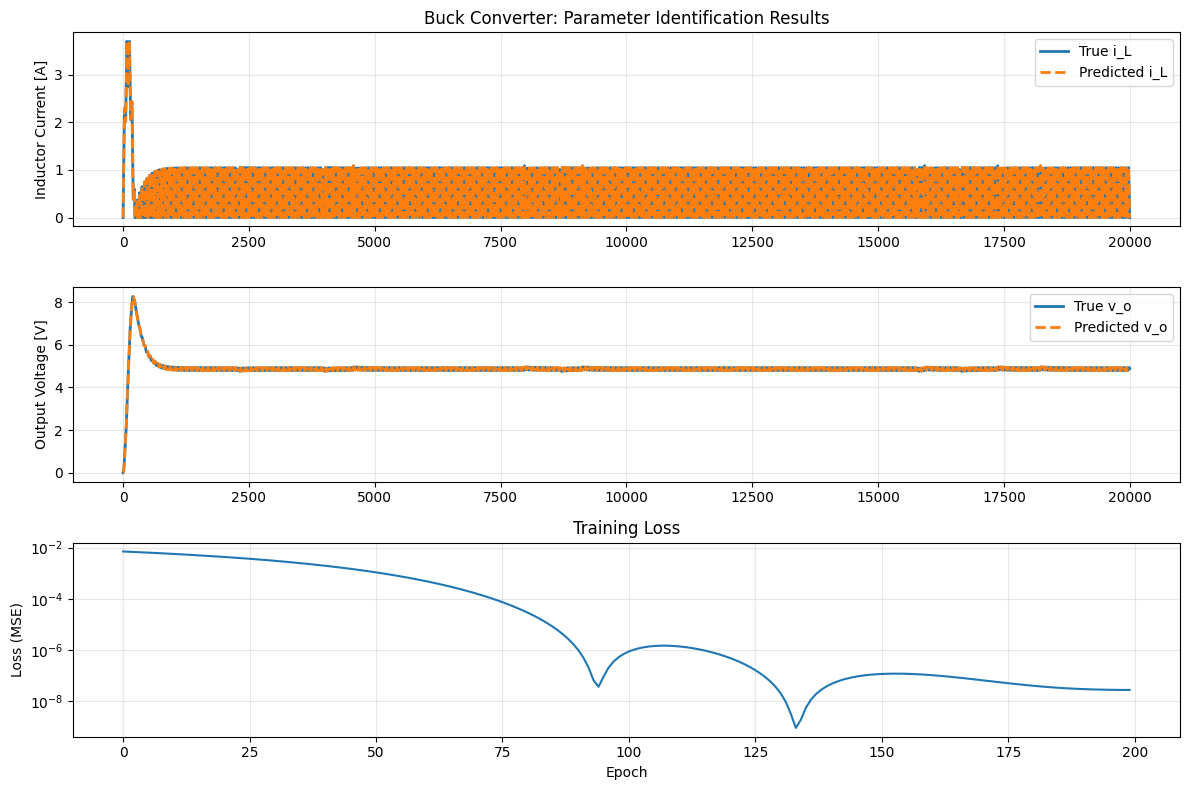

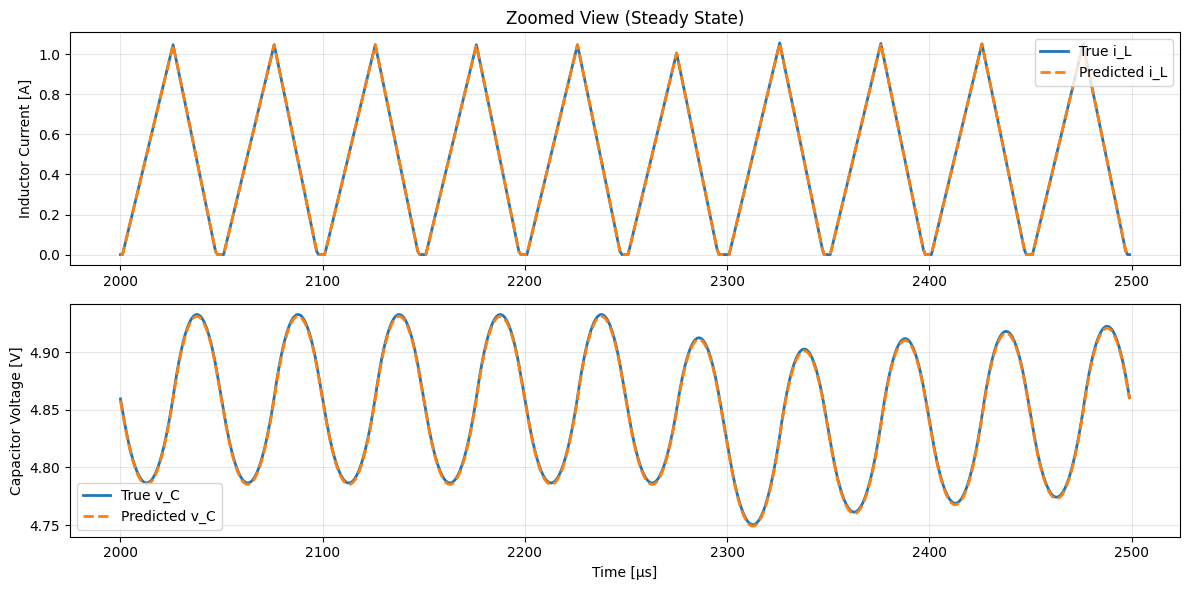

In [7]:
# シミュレーションしてみる
va = torch.tensor(datasets[0]["va"][:-1], dtype=torch.float32).unsqueeze(1)
il = torch.tensor(datasets[0]["il"], dtype=torch.float32)
vo = torch.tensor(datasets[0]["vo"], dtype=torch.float32)

with torch.no_grad():
    h_sim = [h_seq[0, 0].unsqueeze(0)]  # 最初の状態
    for t in range(1, len(va)):
        # va[t-1]を正しい形状 [1, 1] にする
        va_input = va[t - 1].unsqueeze(0)  # [1, 1]の形状にする
        h_next, _ = model(h_sim[-1], va_input)
        h_sim.append(h_next)
    h_sim = torch.cat(h_sim, dim=0)

il_sim = h_sim[:, 0].numpy()
vo_sim = h_sim[:, 1].numpy()


time = np.arange(len(va)) * dt * 1e6  # μs単位

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# インダクタ電流
axes[0].plot(time, il[:-1], label="True i_L", linewidth=2)
axes[0].plot(time, il_sim, "--", label="Predicted i_L", linewidth=2)
axes[0].set_ylabel("Inductor Current [A]")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Buck Converter: Parameter Identification Results")

# キャパシタ電圧
axes[1].plot(time, vo[:-1], label="True v_o", linewidth=2)
axes[1].plot(time, vo_sim, "--", label="Predicted v_o", linewidth=2)
axes[1].set_ylabel("Output Voltage [V]")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 損失関数の履歴
axes[2].semilogy(loss_history)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss (MSE)")
axes[2].grid(True, alpha=0.3)
axes[2].set_title("Training Loss")

plt.tight_layout()
plt.show()

# 一部区間の詳細表示
plt.figure(figsize=(12, 6))
start_idx = 2000
end_idx = 2500

plt.subplot(2, 1, 1)
plt.plot(time[start_idx:end_idx], il[start_idx:end_idx], label="True i_L", linewidth=2)
plt.plot(
    time[start_idx:end_idx],
    il_sim[start_idx:end_idx],
    "--",
    label="Predicted i_L",
    linewidth=2,
)
plt.ylabel("Inductor Current [A]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Zoomed View (Steady State)")

plt.subplot(2, 1, 2)
plt.plot(time[start_idx:end_idx], vo[start_idx:end_idx], label="True v_C", linewidth=2)
plt.plot(
    time[start_idx:end_idx],
    vo_sim[start_idx:end_idx],
    "--",
    label="Predicted v_C",
    linewidth=2,
)
plt.ylabel("Capacitor Voltage [V]")
plt.xlabel("Time [µs]")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

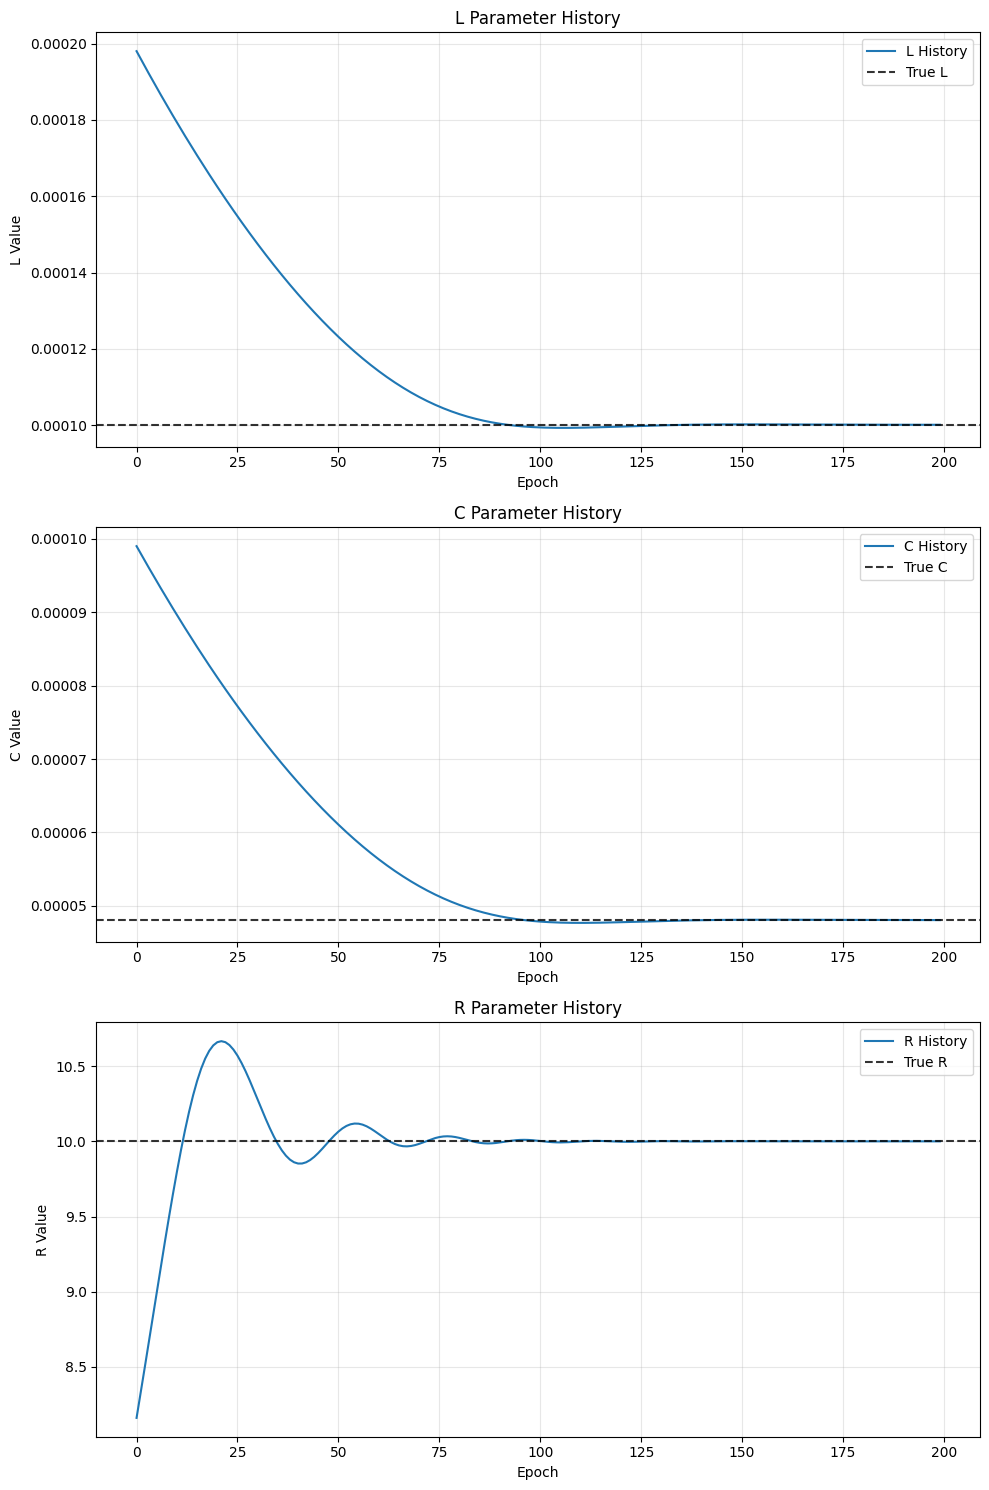

In [8]:
# 各パラメータの遷移

plt.figure(figsize=(10, 15))

# Plot L parameter
plt.subplot(3, 1, 1)
plt.plot(param_history["L"], label="L History")
plt.axhline(y=L_true, color="k", linestyle="--", alpha=0.8, label="True L")
plt.xlabel("Epoch")
plt.ylabel("L Value")
plt.title("L Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C parameter
plt.subplot(3, 1, 2)
plt.plot(param_history["C"], label="C History")
plt.axhline(y=C_true, color="k", linestyle="--", alpha=0.8, label="True C")
plt.xlabel("Epoch")
plt.ylabel("C Value")
plt.title("C Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R parameter
plt.subplot(3, 1, 3)
plt.plot(param_history["R"], label="R History")
plt.axhline(y=R_true, color="k", linestyle="--", alpha=0.8, label="True R")
plt.xlabel("Epoch")
plt.ylabel("R Value")
plt.title("R Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

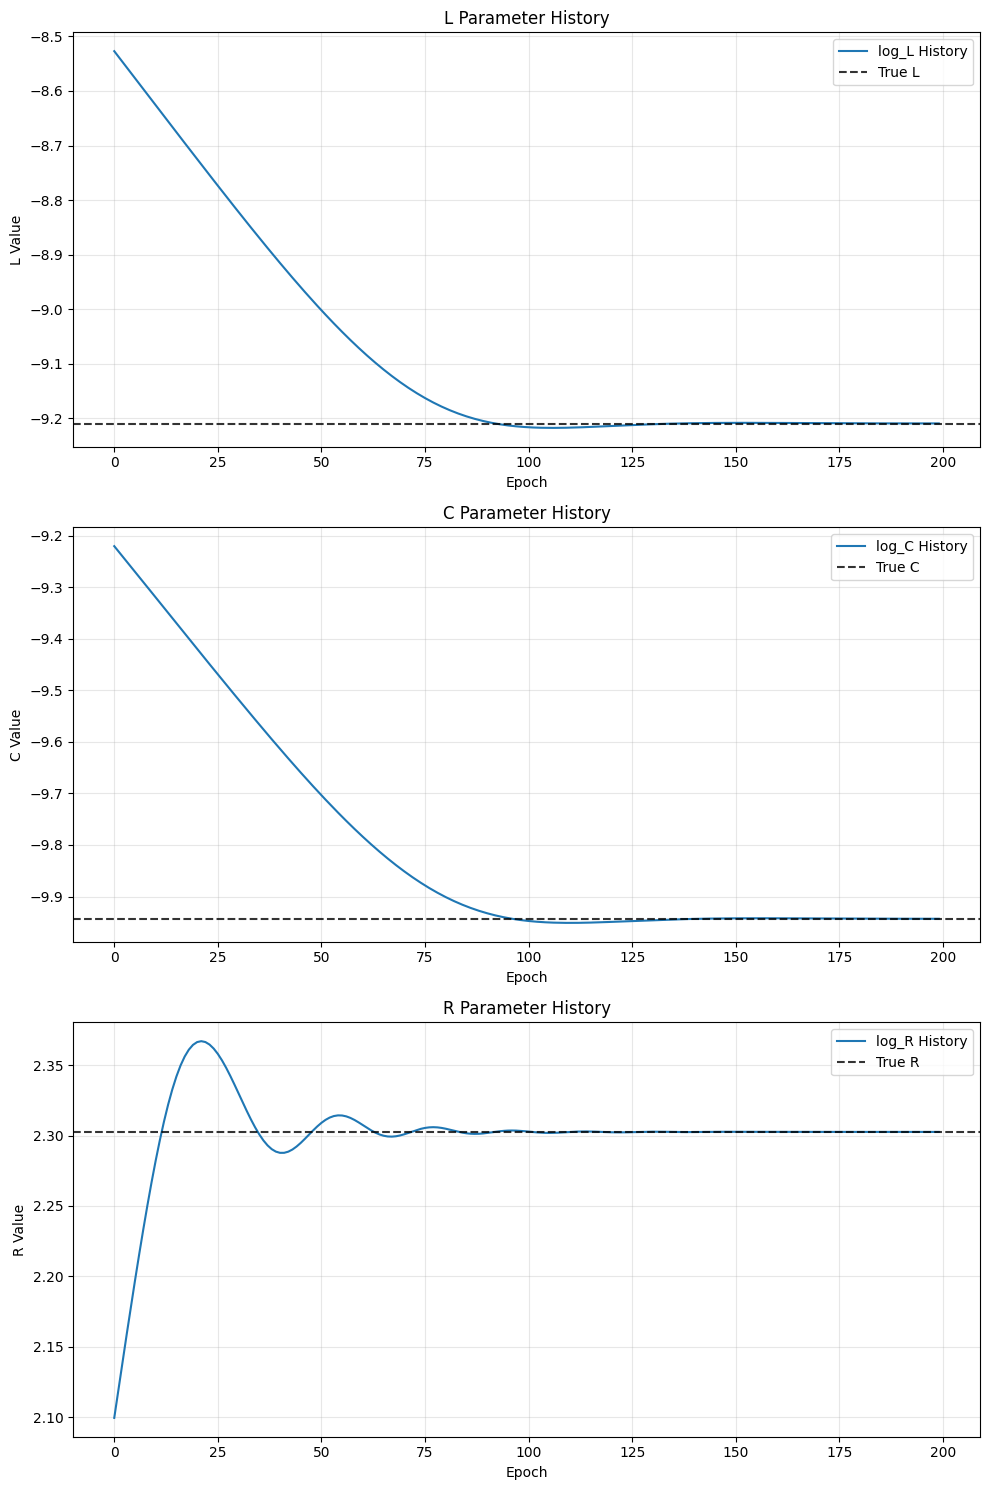

In [9]:
# パラメータとして持っているlogの値をそのままプロットしてみる

plt.figure(figsize=(10, 15))

# Plot L parameter
plt.subplot(3, 1, 1)
plt.plot(param_history["log_L"], label="log_L History")
plt.axhline(y=np.log(L_true), color="k", linestyle="--", alpha=0.8, label="True L")
plt.xlabel("Epoch")
plt.ylabel("L Value")
plt.title("L Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C parameter
plt.subplot(3, 1, 2)
plt.plot(param_history["log_C"], label="log_C History")
plt.axhline(y=np.log(C_true), color="k", linestyle="--", alpha=0.8, label="True C")
plt.xlabel("Epoch")
plt.ylabel("C Value")
plt.title("C Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R parameter
plt.subplot(3, 1, 3)
plt.plot(param_history["log_R"], label="log_R History")
plt.axhline(y=np.log(R_true), color="k", linestyle="--", alpha=0.8, label="True R")
plt.xlabel("Epoch")
plt.ylabel("R Value")
plt.title("R Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# まとめ

```py
L_true = 100e-6
C_true = 48e-6
R_true = 10
```

データ数: 13

```py
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

lr_L = 1e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 200
```

optimizer: AdamW

学習結果

```bash
Loss=2.713636e-08
L=100.1µH (true=100.0)
C=48.1µF (true=48.0)
R=10.00Ω (true=10.0)
```

loss の推移が、谷ができていて、最終的な loss より小さい点が存在している

- うまく収束できていないのか？
